In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
import datetime as dt


In [3]:
import os
print(os.getcwd())
pd.set_option('mode.chained_assignment', None)


C:\Users\Lena\Dokumente\GitHub\DataLiteracy


In [4]:
path = "Daten/data.csv"
df =  pd.read_csv(path,header=1, sep=";", names=['date','Tunnel','Steinlach','Hirschau'], parse_dates=['date']).dropna()
df['date']=pd.to_datetime(df['date']).dt.date
df=df.groupby(['date']).sum()


In [5]:
df_weeks = df.copy()
df_weeks.is_copy = True

In [6]:
weeks = pd.date_range('2018-01-01', '2022-11-27', freq='W').to_numpy()
weeks= np.repeat(weeks, 7)

df_weeks['weekdate']= weeks.tolist()
df_weeks['weekdate']=pd.to_datetime(df_weeks['weekdate']).dt.date
df_weeks = df_weeks.groupby('weekdate').sum()

df_weeks.index = pd.to_datetime(df_weeks.index)
df_weeks['week'] = df_weeks.index.week
df_weeks['year'] = df_weeks.index.year

df_weeks

C:\Users\Lena\AppData\Local\Temp\ipykernel_13576\3009910297.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_weeks['week'] = df_weeks.index.week


,Tunnel,Steinlach,Hirschau,week,year
weekdate,,,,,
2018-01-07,19002,30213,4812,1,2018
2018-01-14,19946,29657,3793,2,2018
2018-01-21,16793,15439,1707,3,2018
2018-01-28,20033,41665,2771,4,2018
2018-02-04,19313,35519,3145,5,2018
...,...,...,...,...,...
2022-10-30,35489,56452,8947,43,2022
2022-11-06,32135,59687,5642,44,2022
2022-11-13,27390,52318,4194,45,2022


In [8]:
#create train and test dataframes
weeks_train = df_weeks.copy()
weeks_train.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2022].index
weeks_train = weeks_train.drop(weeks_to_drop)

weeks_test = df_weeks.copy()
weeks_test.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] != 2022].index
weeks_test = weeks_test.drop(weeks_to_drop)


print(len(weeks_train))
print(len(weeks_test))

208
48


In [9]:
#this is stolen from https://www.kaggle.com/code/ryanholbrook/seasonality
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/week)'}, xlabel='week', ylabel='Tunnel'>

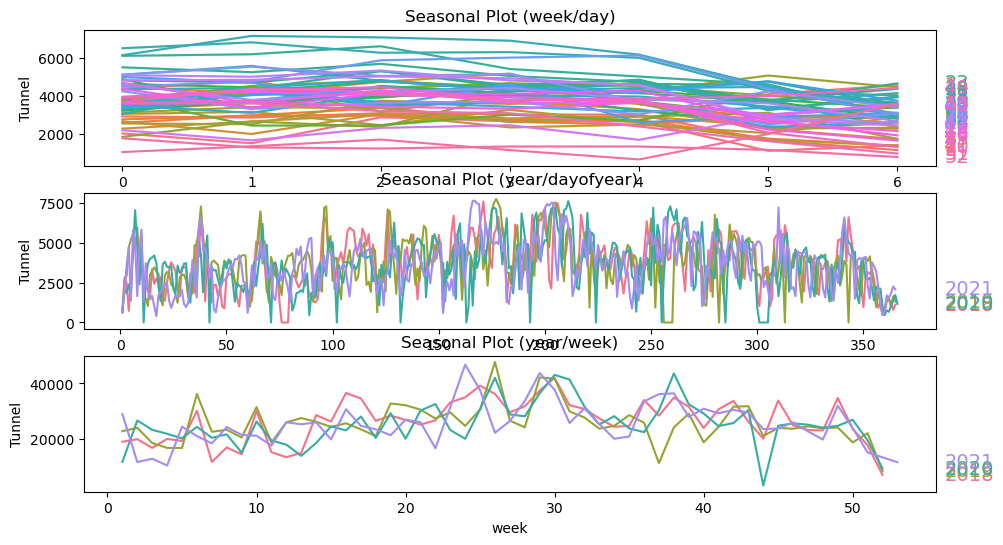

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
seasonal_plot(days_train, y="Tunnel", period="week", freq="day", ax=ax0)
seasonal_plot(days_train, y="Tunnel", period="year", freq="dayofyear", ax=ax1)
seasonal_plot(weeks_train, y="Tunnel", period="year", freq="week", ax=ax2)

In [11]:
dp_days = DeterministicProcess(
    index=days_train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    seasonal=True,
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
Xdays = dp_days.in_sample()
Xdays = Xdays.drop(['trend'], axis=1)

Xdays.head()

dp_weeks = DeterministicProcess(
    index=weeks_train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    seasonal=True,
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
Xweeks = dp_weeks.in_sample()
Xweeks = Xweeks.drop(['trend'], axis=1)

Xweeks.head()

,const,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)",...,"s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)"
weekdate,,,,,,,,,,,,,,,,,,,,,
2018-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-14,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-21,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-28,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02-04,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
model_days = LinearRegression(fit_intercept=False)
_ = model_days.fit(Xdays, days_train['Tunnel'])

y_pred_days = pd.Series(model_days.predict(Xdays), index=days_train['Tunnel'].index)

display(y_pred_days)


model_weeks = LinearRegression(fit_intercept=False)
_ = model_weeks.fit(Xweeks, weeks_train['Tunnel'])

y_pred_weeks = pd.Series(model_weeks.predict(Xweeks), index=weeks_train['Tunnel'].index)

display(y_pred_weeks)


date
2018-01-01    3856.933014
2018-01-02    3946.722488
2018-01-03    4080.961722
2018-01-04    3988.827751
2018-01-05    3765.483254
                 ...     
2021-12-27    3856.933014
2021-12-28    3946.722488
2021-12-29    4080.961722
2021-12-30    3988.827751
2021-12-31    3765.483254
Length: 1461, dtype: float64

weekdate
2018-01-07    16306.00
2018-01-14    24906.75
2018-01-21    17591.00
2018-01-28    17898.75
2018-02-04    16712.75
                ...   
2021-11-28    23438.25
2021-12-05    25860.50
2021-12-12    25319.50
2021-12-19    20829.25
2021-12-26    10030.75
Length: 208, dtype: float64

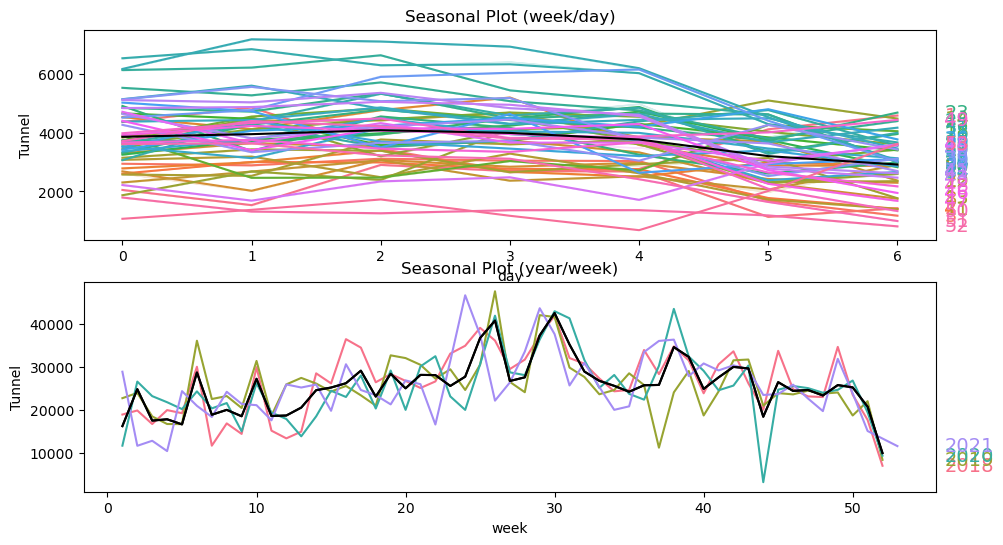

In [13]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(days_train, y="Tunnel", period="week", freq="day", ax=ax0)
ax0.plot(range(7),y_pred_days[:7], color='black')

seasonal_plot(weeks_train, y="Tunnel", period="year", freq="week", ax=ax1)
ax1.plot(range(1,53), y_pred_weeks[:52], color='black')
ax1.plot(range(1,53), y_pred_weeks[52:104], color='black')

In [14]:
#this is stolen from kaggle too

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

C:\Users\Lena\AppData\Local\Temp\ipykernel_13576\585660488.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(df_weeks["Tunnel"])


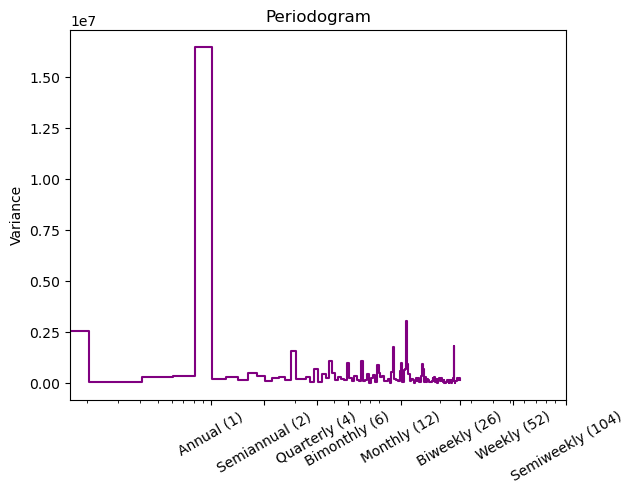

In [15]:
plot_periodogram(df_weeks["Tunnel"])
plt.show()

In [39]:
fourier = CalendarFourier(freq="A", order=3)  # 15 sin/cos pairs for "A"nnual seasonality


In [17]:
weeks_train.index.freq = 'W'
weeks_train.index

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11',
               ...
               '2021-10-24', '2021-10-31', '2021-11-07', '2021-11-14',
               '2021-11-21', '2021-11-28', '2021-12-05', '2021-12-12',
               '2021-12-19', '2021-12-26'],
              dtype='datetime64[ns]', name='weekdate', length=208, freq='W-SUN')

In [18]:
len(df_weeks)

256

In [19]:
len(weeks_train)

208

In [40]:
dp = DeterministicProcess(
    index=weeks_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

X_fore = dp.out_of_sample(steps=len(df_weeks)-len(weeks_train))

3223.8880628127035
5715.020001745371


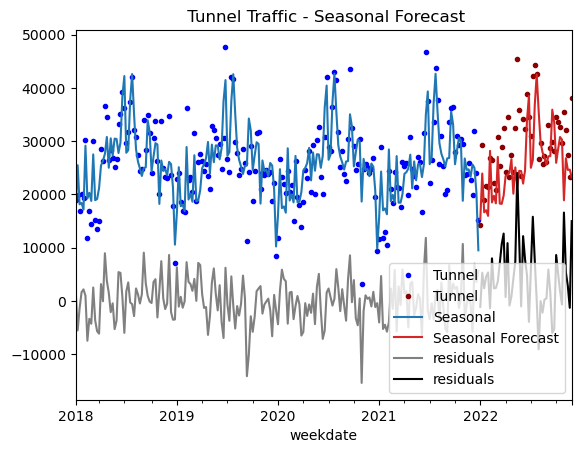

5315.154304916185
11594.16708066016


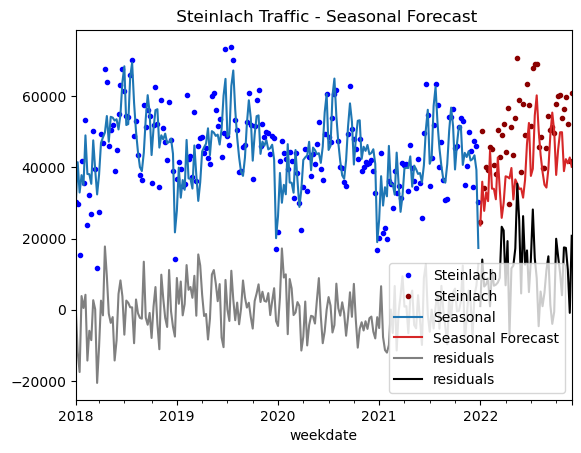

1196.0000762094153
2055.5673850090925


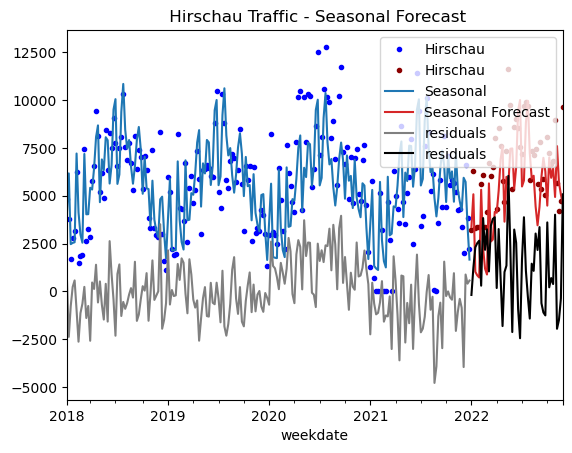

In [41]:
for loc in ["Tunnel","Steinlach","Hirschau"]:
    fig, a = plt.subplots(1,1)
    y = weeks_train[loc]
    y_test = weeks_test[loc]
    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X, y)
    
    y_pred = model.predict(X)
    y_fore = model.predict(X_fore)
    
    train_residuals = y - y_pred
    test_residuals = y_test -y_fore
    train_residuals_abs = np.abs(train_residuals)
    test_residuals_abs = np.abs(test_residuals)
    print(sum(train_residuals_abs)/len(train_residuals_abs))
    print(sum(test_residuals_abs)/len(test_residuals_abs))
    
    y_pred = pd.Series(y_pred, index=y.index)
    y_fore = pd.Series(y_fore, index=X_fore.index)
    tit=f" {loc} Traffic - Seasonal Forecast"

    a = y.plot(color="blue", style='.', title=tit)
    a = y_test.plot(color="darkred", style='.')
    a = y_pred.plot(ax=a, label="Seasonal")
    a = y_fore.plot(ax=a, label="Seasonal Forecast", color='C3')
    a = train_residuals.plot(ax=a, label='residuals', color='grey')
    a = test_residuals.plot(ax=a, label='residuals', color='black')
    _ = a.legend()

    plt.show()

In [29]:
#######for loop through all numbers of fourier terms to check for residuals 

###without seasonal dummies 

max_fourier = 70

residuals_train_f = pd.DataFrame(data=np.zeros([max_fourier,3]), columns=["Tunnel","Steinlach","Hirschau"])
residuals_test_f = pd.DataFrame(data=np.zeros([max_fourier,3]), columns=["Tunnel","Steinlach","Hirschau"])

for i in range(max_fourier):
    
    fourier = CalendarFourier(freq="A", order=i+1)
    
    dp = DeterministicProcess(
        index=weeks_train.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = dp.in_sample()  # create features for dates in tunnel.index
    X_fore = dp.out_of_sample(steps=len(df_weeks)-len(weeks_train))
    
    for loc in ["Tunnel","Steinlach","Hirschau"]:
        y = weeks_train[loc]
        y_test = weeks_test[loc]
        model = LinearRegression(fit_intercept=False)
        _ = model.fit(X, y)
        
        y_pred = model.predict(X)
        y_fore = model.predict(X_fore)
        
        train_res = np.abs(y - y_pred)
        test_res = np.abs(y_test - y_fore)
        
        residuals_train_f[loc][i] = sum(train_res)/len(train_res)
        residuals_test_f[loc][i] = sum(test_res)/len(test_res)

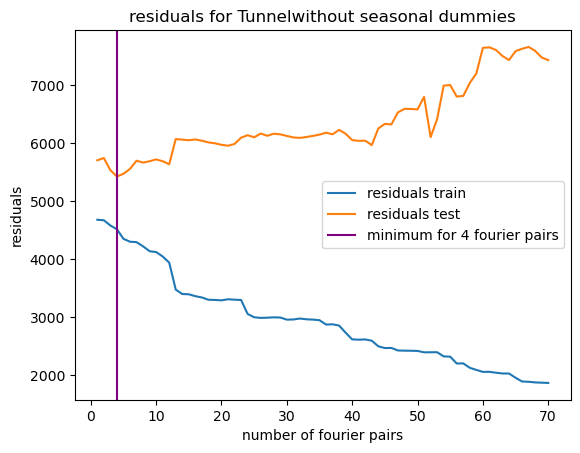

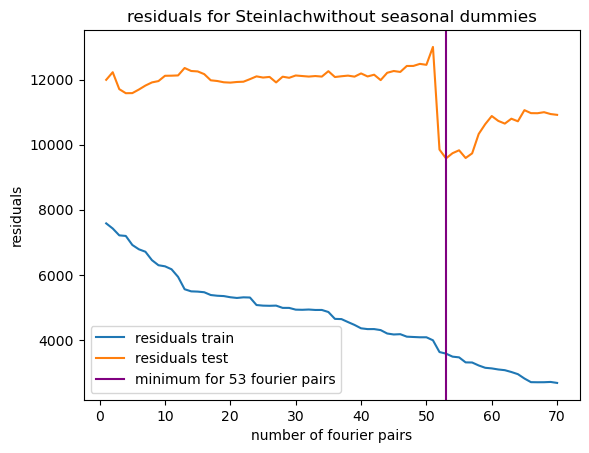

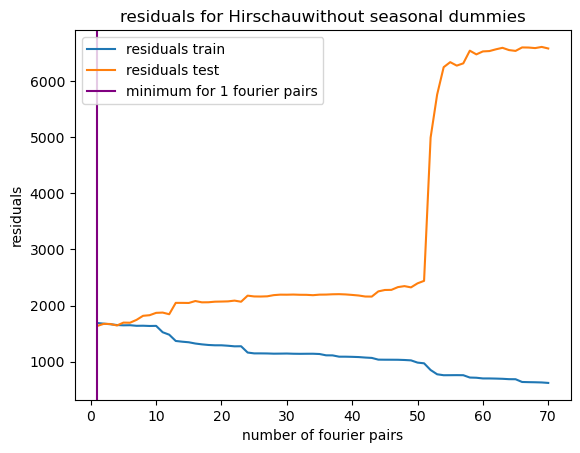

In [31]:
for loc in ["Tunnel","Steinlach","Hirschau"]:
    plt.plot(range(1,max_fourier+1), residuals_train_f[loc], label='residuals train')
    plt.plot(range(1,max_fourier+1), residuals_test_f[loc], label='residuals test')
    test_min = np.argmin(residuals_test_f[loc].values)+1
    plt.axvline(test_min, color='purple', label='minimum for '+str(test_min)+' fourier pairs')
    plt.xlabel('number of fourier pairs')
    plt.ylabel('residuals')
    plt.title('residuals for ' + loc + ' without seasonal dummies')
    plt.legend()
    plt.show()

In [42]:
#######for loop through all numbers of fourier terms to check for residuals 

###with seasonal dummies 

max_fourier = 70

residuals_train_sf = pd.DataFrame(data=np.zeros([max_fourier,3]), columns=["Tunnel","Steinlach","Hirschau"])
residuals_test_sf = pd.DataFrame(data=np.zeros([max_fourier,3]), columns=["Tunnel","Steinlach","Hirschau"])

for i in range(max_fourier):
    
    fourier = CalendarFourier(freq="A", order=i+1)
    
    dp = DeterministicProcess(
        index=weeks_train.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = dp.in_sample()  # create features for dates in tunnel.index
    X_fore = dp.out_of_sample(steps=len(df_weeks)-len(weeks_train))
    
    for loc in ["Tunnel","Steinlach","Hirschau"]:
        y = weeks_train[loc]
        y_test = weeks_test[loc]
        model = LinearRegression(fit_intercept=False)
        _ = model.fit(X, y)
        
        y_pred = model.predict(X)
        y_fore = model.predict(X_fore)
        
        train_res = np.abs(y - y_pred)
        test_res = np.abs(y_test - y_fore)
        
        residuals_train_sf[loc][i] = sum(train_res)/len(train_res)
        residuals_test_sf[loc][i] = sum(test_res)/len(test_res)


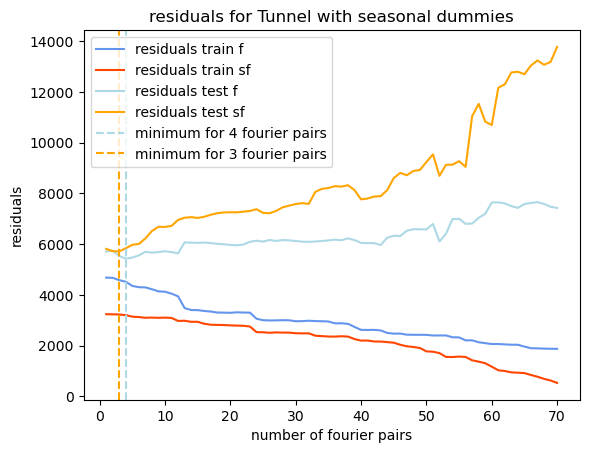

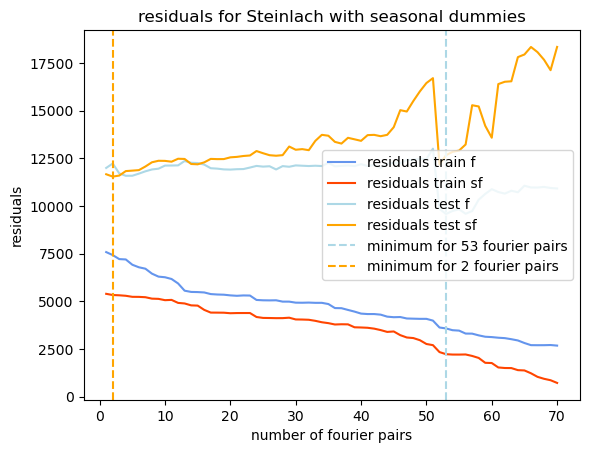

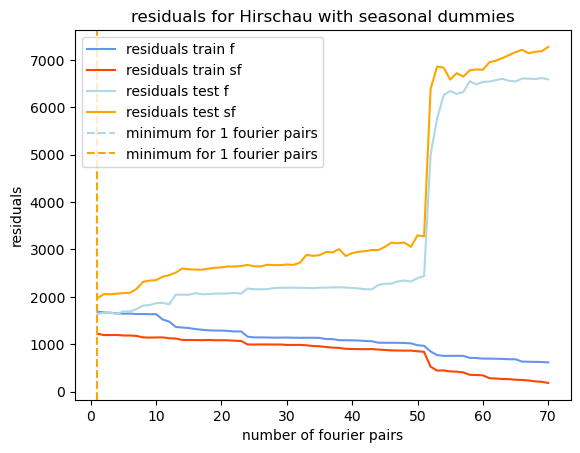

In [59]:
for loc in ["Tunnel","Steinlach","Hirschau"]:
    plt.plot(range(1,max_fourier+1), residuals_train_f[loc], color='cornflowerblue', label='residuals train f')
    plt.plot(range(1,max_fourier+1), residuals_train_sf[loc], color='orangered', label='residuals train sf')
    plt.plot(range(1,max_fourier+1), residuals_test_f[loc], color='lightblue', label='residuals test f')
    plt.plot(range(1,max_fourier+1), residuals_test_sf[loc], color='orange',label='residuals test sf')
    test_min_f = np.argmin(residuals_test_f[loc].values)+1
    plt.axvline(test_min_f, color='lightblue', label='minimum for '+str(test_min_f)+' fourier pairs', linestyle='--')
    test_min_sf = np.argmin(residuals_test_sf[loc].values)+1
    plt.axvline(test_min_sf, color='orange', label='minimum for '+str(test_min_sf)+' fourier pairs', linestyle='--')
    plt.xlabel('number of fourier pairs')
    plt.ylabel('residuals')
    plt.title('residuals for ' + loc + ' with seasonal dummies')
    plt.legend()
    plt.show()